In [3]:
import yaml
import argparse
import os
import sys
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Go up 1 directory level to import the helpers foldes
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

# From local helper files
from helpers.helper_evaluation import set_all_seeds, set_deterministic
from helpers.helper_train import train_model
from helpers.helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helpers.helper_dataset import get_dataloaders_caltech101

In [5]:
##########################
### SETTINGS
##########################
parser = argparse.ArgumentParser()
script_dir = os.path.dirname(os.path.abspath('cnn1-v1.ipynb'))
default_yaml = os.path.join(script_dir, 'config-v1.yaml')
parser.add_argument('--settings_path',
                    type=str,
                    default=default_yaml,
                    help='Path to the YAML config file')

args, unknown = parser.parse_known_args() # Ignore unknown arguments

# Load YAML settings
with open(args.settings_path, 'r') as file:
    SETTINGS = yaml.load(file, Loader=yaml.FullLoader)

if torch.cuda.is_available():
    DEVICE = torch.device(f"cuda:{SETTINGS.get('cuda_device', 0)}")
else:
    DEVICE = torch.device('cpu')

# Set random seeds, etc.
set_all_seeds(SETTINGS['random_seed'])
# set_deterministic

In [6]:
##########################
### DATASET & DATALOADERS
##########################
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda image: image.convert('RGB')),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(30),
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda image: image.convert('RGB')),
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.CenterCrop((64, 64)),
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader, valid_loader, test_loader = get_dataloaders_caltech101(
    batch_size=SETTINGS['batch_size'],
    validation_fraction=SETTINGS['validation_percent'],
    train_transforms=train_transform,
    test_transforms=test_transform
)

##########################
### MODEL DEFINITION
##########################

class myCNN(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # (1) 1st Convolutional Layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=11, stride=4, padding=2),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        # (2) 2nd Convolutional Layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        # (3) 3rd Convolutional Layer
        self.conv3 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        # (4) 2 Fully Connected Layers + Activation
        self.fc1 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(384 * 1 * 1, 512),
            nn.Tanh(),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        return x


model = myCNN(num_classes=SETTINGS['num_classes'])

model.to(SETTINGS['cuda_device'])


##########################
### WEIGHT INITIALIZATION
##########################
def apply_weight_init(model, init_name='none'):
    """
    Apply weight initialization to Conv2d and Linear layers
    within an nn.Sequential model.
    """
    for layer in model.modules():
        if isinstance(layer, (nn.Conv2d, nn.Linear)):
            if init_name == 'xavier_uniform':
                nn.init.xavier_uniform_(layer.weight)
                nn.init.constant_(layer.bias, 0.0)
            elif init_name == 'kaiming_normal':
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                nn.init.constant_(layer.bias, 0.0)
            elif init_name == 'orthogonal':
                nn.init.orthogonal_(layer.weight)
                nn.init.constant_(layer.bias, 0.0)
            else:
                # If none or unknown, just leave PyTorch default
                pass

# Read weight init scheme from config
weight_init_config = SETTINGS.get('weight_init', {})
weight_init_name = weight_init_config.get('name', 'none')

apply_weight_init(model, init_name=weight_init_name)

##########################
### OPTIMIZER
##########################
optimizer_config = SETTINGS.get('optimizer', {})
optimizer_name = optimizer_config.get('name', 'Adam') # Default to Adam

weight_decay = float(optimizer_config.get('weight_decay', 0.0))
momentum = float(optimizer_config.get('momentum', 0.0)) # Default momentum for SGD
alpha = float(optimizer_config.get('alpha', 0.99)) # Default alpha for RMSprop

if optimizer_name == 'Adam':
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=SETTINGS['learning_rate'],
        weight_decay=weight_decay
    )
    
elif optimizer_name == 'SGD':
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=SETTINGS['learning_rate'],
        momentum=momentum,
        weight_decay=weight_decay
    )

elif optimizer_name == 'RMSprop':
    optimizer = torch.optim.RMSProp(
        model.parameters(),
        lr=SETTINGS['learning_rate'],
        momentum=momentum,
        weight_decay=weight_decay,
        alpha=alpha
    )

else:
    raise ValueError(f"Unknown optimizer: {optimizer_name}")

##########################
### LR SCHEDULER
##########################
scheduler_config = SETTINGS.get('scheduler', {})
scheduler_name = scheduler_config.get('name', 'None')

# Default to ReduceLROnPlateau, if not specified
if scheduler_name == 'ReduceLROnPlateau':
    factor = scheduler_config.get('factor', 0.1)
    mode = scheduler_config.get('mode', 'max')
    patience = scheduler_config.get('patience', 5)
    verbose = scheduler_config.get('verbose', True)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimizer,
        factor=factor,
        mode=mode,
        patience=patience
    )
elif scheduler_name == 'ExponentialLR':
    gamma = scheduler_config.get('gamma', 0.99)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
elif scheduler_name == 'StepLR':
    step_size = scheduler_config.get('step_size', 30)
    gamma = scheduler_config.get('gamma', 0.1)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
elif scheduler_name.lower() == 'none':
    scheduler = None
else:
    raise ValueError(f"Unknown scheduler: {scheduler_name}")

Files already downloaded and verified


Epoch: 001/100 | Batch 0000/0032 | Loss: 4.6660
Epoch: 001/100 | Train: 28.98% | Validation: 22.40%
Time elapsed: 0.37 min
Epoch: 002/100 | Batch 0000/0032 | Loss: 3.6142
Epoch: 002/100 | Train: 34.01% | Validation: 24.94%
Time elapsed: 0.74 min
Epoch: 003/100 | Batch 0000/0032 | Loss: 3.2477
Epoch: 003/100 | Train: 40.16% | Validation: 24.02%
Time elapsed: 1.09 min
Epoch: 004/100 | Batch 0000/0032 | Loss: 2.8823
Epoch: 004/100 | Train: 43.43% | Validation: 19.86%
Time elapsed: 1.45 min
Epoch: 005/100 | Batch 0000/0032 | Loss: 2.7012
Epoch: 005/100 | Train: 47.00% | Validation: 20.32%
Time elapsed: 1.82 min
Epoch: 006/100 | Batch 0000/0032 | Loss: 2.4834
Epoch: 006/100 | Train: 49.80% | Validation: 21.02%
Time elapsed: 2.20 min
Epoch: 007/100 | Batch 0000/0032 | Loss: 2.2755
Epoch: 007/100 | Train: 52.14% | Validation: 15.70%
Time elapsed: 2.56 min
Epoch: 008/100 | Batch 0000/0032 | Loss: 2.4024
Epoch: 008/100 | Train: 55.83% | Validation: 17.78%
Time elapsed: 2.93 min
Epoch: 009/100 |

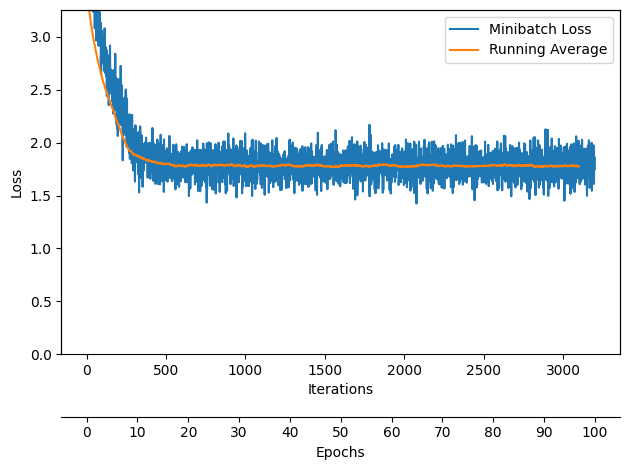

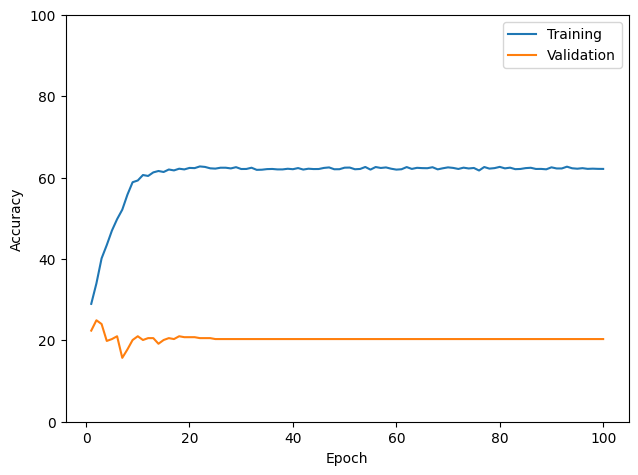

In [7]:
##########################
### TRAINING LOOP
##########################
# The helper_train.py presumably expects scheduler if not None,
# and you might specify how it’s applied (e.g., 'valid_acc').
minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=SETTINGS['num_epochs'],
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=SETTINGS['cuda_device'],
    logging_interval=100,
    scheduler=scheduler,
    scheduler_on='valid_acc'  # or 'train_acc' or 'valid_loss'
)

##########################
### PLOTTING
##########################
plot_training_loss(
    minibatch_loss_list=minibatch_loss_list,
    num_epochs=SETTINGS['num_epochs'],
    iter_per_epoch=len(train_loader),
    results_dir=None,
    averaging_iterations=100
)
plt.show()

plot_accuracy(
    train_acc_list=train_acc_list,
    valid_acc_list=valid_acc_list,
    results_dir=None
)
plt.ylim([0, 100])
plt.show()

In [8]:
from torchsummary import summary

summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 15, 15]          23,296
              Tanh-2           [-1, 64, 15, 15]               0
         MaxPool2d-3             [-1, 64, 7, 7]               0
            Conv2d-4            [-1, 192, 7, 7]         307,392
              Tanh-5            [-1, 192, 7, 7]               0
         MaxPool2d-6            [-1, 192, 3, 3]               0
            Conv2d-7            [-1, 384, 3, 3]         663,936
              Tanh-8            [-1, 384, 3, 3]               0
         MaxPool2d-9            [-1, 384, 1, 1]               0
          Dropout-10                  [-1, 384]               0
           Linear-11                  [-1, 512]         197,120
             Tanh-12                  [-1, 512]               0
          Dropout-13                  [-1, 512]               0
           Linear-14                  [

In [9]:
##########################
### SAVE MODEL
##########################
model.to(torch.device('cpu'))
os.makedirs('./models/cnn2-v1', exist_ok=True)
torch.save(model.state_dict(), './models/cnn2-v1/cnn2-v1.pt')
torch.save(optimizer.state_dict(), './models/cnn2-v1/cnn2-v1-optimizer.pt')
torch.save(scheduler.state_dict(), './models/cnn2-v1/cnn2-v1-scheduler.pt')